<a href="https://colab.research.google.com/github/Paymanshus/ML-Sem-V/blob/master/ML_J046_Lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis of OpenML data using machine learning models

## Objectives
- Download from Repository data
- Perform Time series analysis on given dataset
- Select correct architecture for single step single output prediction
- List hyper-parameters used 


In [1]:
import os
import datetime
# For data manipulation
import numpy as np
import pandas as pd
# For data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# For building model and loading dataset
import tensorflow as tf
# Set basic configurations
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


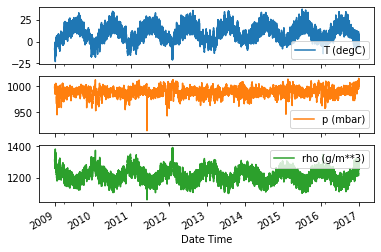

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)'] # Columns we want to plot
plot_features = df[plot_cols] # Getting the columns
plot_features.index = date_time # Setting the index as date time
_ = plot_features.plot(subplots=True)

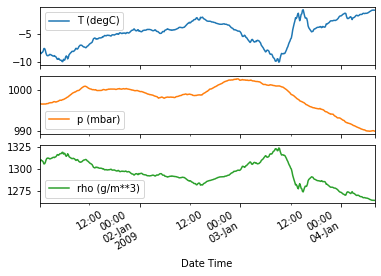

In [6]:
# Taking only first 480 points
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
# Plotting
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


In [8]:
# Getting indices of wv and max. wv with value -9999
bad_wv = df['wv (m/s)'] == -9999.0
bad_max_wv = df['max. wv (m/s)'] == -9999.0
# Repalcing the incorrect values with 0.0
df.loc[bad_wv,'wv (m/s)']  = 0.0
df.loc[bad_max_wv, 'max. wv (m/s)']  = 0.0
# Checking if the above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
# Convert to radians
wd_rad = df.pop('wd (deg)')*np.pi / 180
# Calculate the wind x and y components
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
# Calculate the max wind x and y components
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [11]:

# Dictionary of column names and their indices, i.e., assigning indices to column names
column_indices = {name: i for i, name in enumerate(df.columns)}
# Number of rows
n = len(df)
#  Splitting the dataset with a 70:20:10 split
train_df = df[0:int(n*0.7)] # From 0% to 70%
val_df = df[int(n*0.7):int(n*0.9)] # From 70% to 90%
test_df = df[int(n*0.9):] # All above 90%
# Number of features in our dataset
num_features = df.shape[1]
print(f'Total number of features: {num_features}')

Total number of features: 19


In [12]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

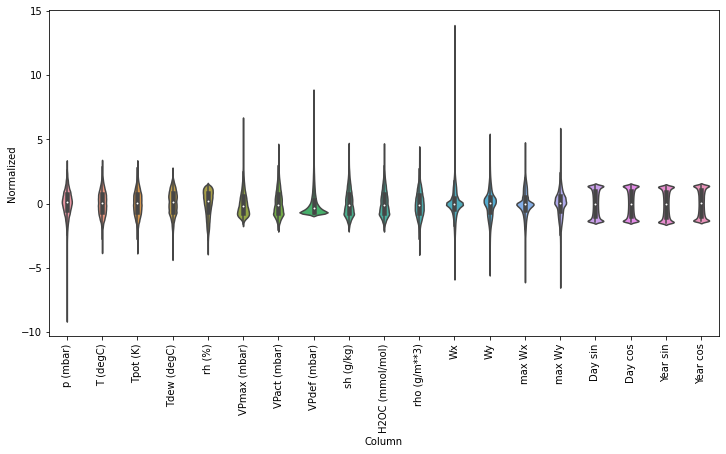

In [13]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
df_temp = pd.DataFrame(df['T (degC)'])
df_temp.index = date_time 
df_temp.head()

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [15]:
import matplotlib
import matplotlib.pyplot as plt
!pip install calmap
import calmap
# Defining figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

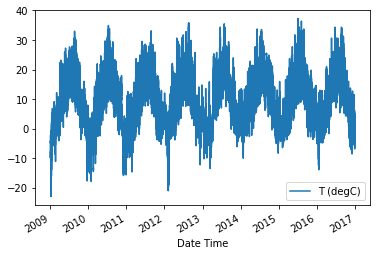

In [16]:
# Plot all temperature
df_temp.plot()
plt.show()

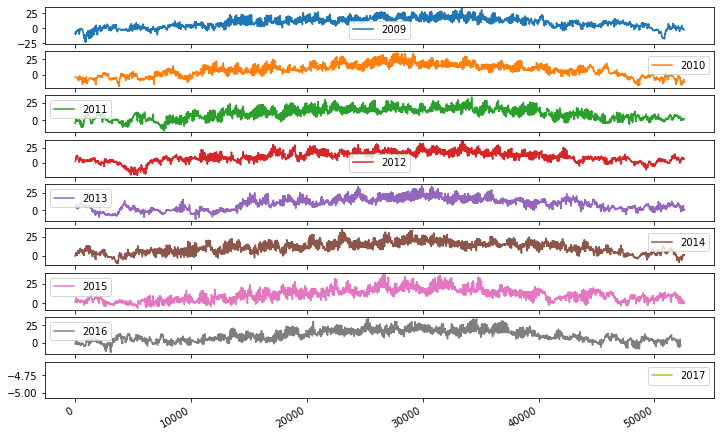

In [17]:
# Group values of different years
group_years = df_temp.groupby(df_temp.index.year)
years = pd.DataFrame()
for name, group in group_years:
    values = group['T (degC)'].values
    years[name] = pd.Series(values)
 
# Plot data   
years.plot(subplots=True, legend=True, figsize=(12,8))
plt.show()

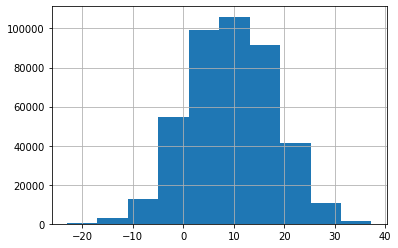

In [18]:
temp = df_temp['T (degC)']
# Plotting the Series
temp.hist()
plt.show()

In [19]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data. Refer to the previous chapter for the DataFrames.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [20]:
# Predicting one hour into the future by using a data window of the past 6 hours
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
print(f'First Window: \n{w1}')
# Predicting 24 hours into the future by using a data window of the past 24 hours.
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
print(f'\nSecond Window: \n{w2}')

First Window: 
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Second Window: 
Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']


In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
WindowGenerator.split_window = split_window

In [22]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])
example_inputs, example_labels = w1.split_window(example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds
WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)
@property
def val(self):
  return self.make_dataset(self.val_df)
@property
def test(self):
  return self.make_dataset(self.test_df)
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
# Instantiatie and compile the model
baseline = Baseline(label_index=column_indices['T (degC)'])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2629/2629 [==============================] - 7s 3ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [31]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [32]:
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0221 - mean_absolute_error: 0.0600 - val_loss: 8.6717e-04 - val_mean_absolute_error: 0.0207
Epoch 2/20
9200/9200 [==============================] - 31s 3ms/step - loss: 7.7624e-04 - mean_absolute_error: 0.0193 - val_loss: 7.2344e-04 - val_mean_absolute_error: 0.0187
Epoch 3/20
9200/9200 [==============================] - 31s 3ms/step - loss: 7.4169e-04 - mean_absolute_error: 0.0187 - val_loss: 7.1935e-04 - val_mean_absolute_error: 0.0186
Epoch 4/20
9200/9200 [==============================] - 31s 3ms/step - loss: 7.4153e-04 - mean_absolute_error: 0.0187 - val_loss: 7.2206e-04 - val_mean_absolute_error: 0.0188
Epoch 5/20
9200/9200 [==============================] - 31s 3ms/step - loss: 7.3995e-04 - mean_absolute_error: 0.0187 - val_loss: 7.1515e-04 - val_mean_absolute_error: 0.0186
Epoch 6/20
9200/9200 [==============================] - 31s 3ms/step - loss: 7.4176e-04 - mean_absolute_error: 0.0187 - val_loss:

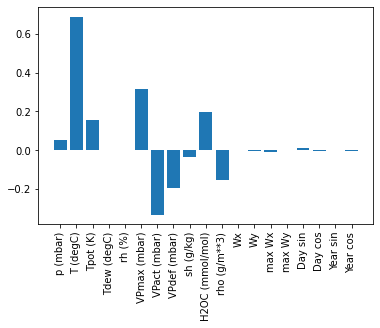

In [33]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [35]:
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
9200/9200 [==============================] - 35s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0260 - val_loss: 7.8753e-04 - val_mean_absolute_error: 0.0199
Epoch 2/20
9200/9200 [==============================] - 35s 4ms/step - loss: 7.7281e-04 - mean_absolute_error: 0.0195 - val_loss: 6.5634e-04 - val_mean_absolute_error: 0.0175
Epoch 3/20
9200/9200 [==============================] - 35s 4ms/step - loss: 7.2932e-04 - mean_absolute_error: 0.0187 - val_loss: 6.5372e-04 - val_mean_absolute_error: 0.0173
Epoch 4/20
9200/9200 [==============================] - 35s 4ms/step - loss: 7.1036e-04 - mean_absolute_error: 0.0184 - val_loss: 6.3729e-04 - val_mean_absolute_error: 0.0172
Epoch 5/20
9200/9200 [==============================] - 34s 4ms/step - loss: 6.9698e-04 - mean_absolute_error: 0.0181 - val_loss: 6.3672e-04 - val_mean_absolute_error: 0.0173
Epoch 6/20
9200/9200 [==============================] - 34s 4ms/step - loss: 6.8381e-04 - mean_absolute_error: 0.0179 - val_loss: